# Data Preprocessing & Feature Engineering:
Now that we've wrangled our data and have done some exploratory analysis, let's move onto the feature engineering step.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer

In [9]:
#Importing the dataframe we saved from our previous "Data Wrangling and Exploratory Data Analysis" Notebook
df = pd.read_csv('WnvDataframe',parse_dates = ['Date'])

# Feature 1: Creating Days of the Week

In [10]:
daysofweek = []
for date in df['Date'].dt.dayofweek:
    if date == 0:
        daysofweek.append('Monday')
    elif date == 1:
        daysofweek.append('Tuesday')
    elif date == 2:
        daysofweek.append('Wednesday')
    elif date == 3:
        daysofweek.append('Thursday')
    elif date == 4:
        daysofweek.append('Friday')
    elif date == 5:
        daysofweek.append('Saturday')
    else:
        daysofweek.append('Sunday')
df['DayOfWeek'] = daysofweek
df2 = pd.get_dummies(df, columns=['DayOfWeek'],prefix='',prefix_sep='')

In [11]:
df.groupby('DayOfWeek').sum()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,Depart,...,ResultDir,AvgSpeed,BR,DZ,FG,HZ,RA,TS,TSRA,VCTS
DayOfWeek,,,,,,,,,,,,,,,,,,,,,
Friday,140719,157547.1691,-330152.5122,30183,40740,135,299186.0,234001.0,267550.0,775.0,...,62560,28656.40,1209,125,0,288,1609,523,688,0
Monday,42747,55040.5721,-115356.2525,10389,16469,16,113040.0,86912.0,100182.0,7893.0,...,29447,10606.30,265,0,0,178,254,0,317,0
Thursday,91494,107775.2096,-225906.4633,20199,34710,215,207314.5,159131.0,183833.0,5218.0,...,45600,18177.75,747,45,255,760,734,233,374,121
Tuesday,38591,44193.1018,-92601.9271,8197,11514,68,89049.0,68199.0,78894.0,5961.0,...,19296,8746.05,618,0,0,281,360,23,93,254
Wednesday,61385,75026.9388,-157358.0846,13184,31606,117,152031.5,120434.5,136715.0,8942.0,...,26165,12120.30,637,93,0,773,728,544,637,129


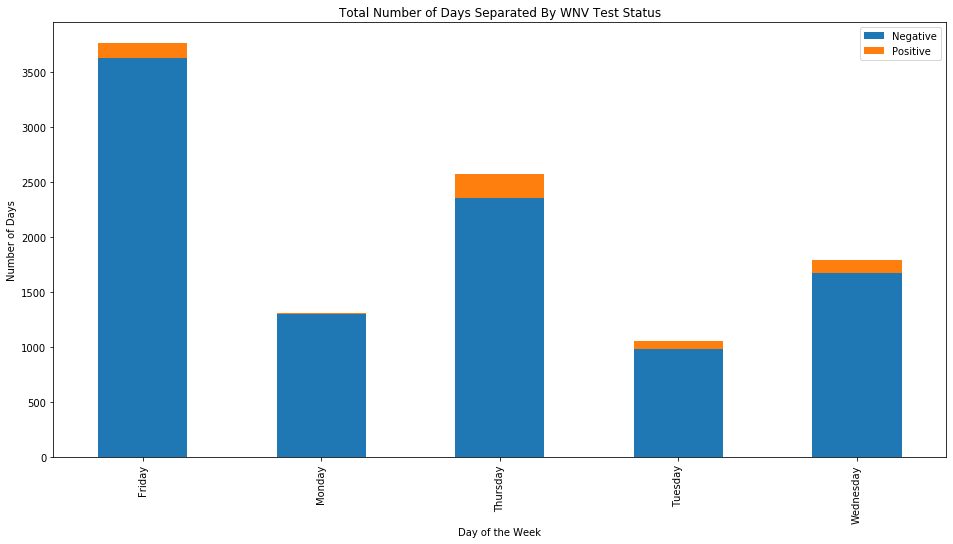

In [12]:
df['Counter'] = 1
df_dayofweek = df.groupby(['DayOfWeek','WnvPresent']).sum()
plt.rcParams["figure.figsize"] = (16,8)
df_dayofweek.Counter.unstack().plot.bar(stacked=True)
plt.title('Total Number of Days Separated By WNV Test Status')
plt.legend(labels=['Negative','Positive'])
plt.ylabel('Number of Days')
plt.xlabel('Day of the Week')
plt.show();

# Feature 2: Month & Year
We previously explored some trends in the data based on the month and year but now let's go ahead and actually make these components separate features in our dataset.

In [16]:
df['Date'].dt.month

0        5
1        5
2        5
3        5
4        5
        ..
10501    9
10502    9
10503    9
10504    9
10505    9
Name: Date, Length: 10506, dtype: int64

In [21]:
months = []
for date in df['Date'].dt.month:
    if date == 5:
        months.append('May')
    elif date == 6:
        months.append('June')
    elif date == 7:
        months.append('July')
    elif date == 8:
        months.append('August')
    elif date == 9:
        months.append('September')
    else:
        months.append('October')
df2['Month'] = months
df2 = pd.get_dummies(df2, columns=['Month'],prefix='',prefix_sep='')

# Feature 3: Days Since Previous Weather Condition

In [22]:
df2['TimeSinceLastBR'] = df2['Date'] - df2.groupby(df2['BR'].eq(1).cumsum())['Date'].transform('min')
df2['TimeSinceLastDZ'] = df2['Date'] - df2.groupby(df2['DZ'].eq(1).cumsum())['Date'].transform('min')
df2['TimeSinceLastFG'] = df2['Date'] - df2.groupby(df2['FG'].eq(1).cumsum())['Date'].transform('min')
df2['TimeSinceLastHZ'] = df2['Date'] - df2.groupby(df2['HZ'].eq(1).cumsum())['Date'].transform('min')
df2['TimeSinceLastRA'] = df2['Date'] - df2.groupby(df2['RA'].eq(1).cumsum())['Date'].transform('min')
df2['TimeSinceLastTS'] = df2['Date'] - df2.groupby(df2['TS'].eq(1).cumsum())['Date'].transform('min')
df2['TimeSinceLastTSRA'] = df2['Date'] - df2.groupby(df2['TSRA'].eq(1).cumsum())['Date'].transform('min')
df2['TimeSinceLastVCTS'] = df2['Date'] - df2.groupby(df2['VCTS'].eq(1).cumsum())['Date'].transform('min')
# There are ~two year gaps between the data - we want to mark off the start of a new year of data with "N/A" instead of 600+ days
for j in range(44,52):
    for i in range(len(df2.iloc[:,j])):
        if df2.iloc[i,j] > pd.Timedelta(days=365):
            df2.iloc[i,j] = np.nan
        else:
            pass
        try:
            df2.iloc[i,j] = float(df2.iloc[i,j].days) #Convert timedelta into float data type so it computes better with the other features.
        except:
            pass
    df2.iloc[:,j] = pd.to_numeric(df2.iloc[:,j],errors='coerce')

In [23]:
df2.corr()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,Depart,...,TimeSinceLastRA,TimeSinceLastTS,TimeSinceLastTSRA,TimeSinceLastVCTS,August,July,June,May,October,September
Block,1.000000,0.091110,-0.090339,0.222134,-0.172388,0.004877,-0.001626,-0.012585,-0.006533,-0.002674,...,0.042749,0.010667,0.032596,0.033612,-0.011011,0.013670,-0.016017,0.004357,0.011912,0.006837
Latitude,0.091110,1.000000,-0.701833,0.444019,-0.184790,0.028698,-0.065804,-0.097396,-0.084929,-0.084895,...,0.095367,0.108780,0.103652,0.102024,-0.118773,0.044615,0.100878,0.001735,-0.005059,0.005682
Longitude,-0.090339,-0.701833,1.000000,-0.456749,0.036611,-0.060349,0.081052,0.101176,0.095625,0.105599,...,-0.088217,-0.138356,-0.110220,-0.141713,0.123338,-0.047897,-0.115043,0.010663,0.012519,-0.000819
AddressAccuracy,0.222134,0.444019,-0.456749,1.000000,-0.248414,0.008064,-0.074840,-0.107253,-0.094777,-0.098285,...,0.083304,0.087779,0.095598,0.086530,-0.089163,0.032054,0.087727,0.006738,0.007295,-0.010230
NumMosquitos,-0.172388,-0.184790,0.036611,-0.248414,1.000000,0.196820,0.159310,0.196325,0.187541,0.104274,...,-0.109673,-0.225854,-0.128372,-0.215072,0.120953,0.051253,-0.059805,-0.056290,-0.060112,-0.108140
WnvPresent,0.004877,0.028698,-0.060349,0.008064,0.196820,1.000000,0.048244,0.074048,0.064256,0.055436,...,0.004523,-0.038752,0.077516,-0.044538,0.160653,-0.089645,-0.097452,-0.021121,-0.033304,0.009075
Tmax,-0.001626,-0.065804,0.081052,-0.074840,0.159310,0.048244,1.000000,0.785216,0.950719,0.820943,...,-0.029365,-0.439570,-0.316385,-0.408941,0.200574,0.134025,-0.170708,-0.124552,-0.109540,-0.158034
Tmin,-0.012585,-0.097396,0.101176,-0.107253,0.196325,0.074048,0.785216,1.000000,0.938078,0.714957,...,-0.096334,-0.452864,-0.360305,-0.540345,0.336951,0.151749,-0.225109,-0.081137,-0.287725,-0.229006
Tavg,-0.006533,-0.084929,0.095625,-0.094777,0.187541,0.064256,0.950719,0.938078,1.000000,0.814752,...,-0.065011,-0.474331,-0.359024,-0.498800,0.282570,0.151273,-0.209874,-0.109610,-0.200608,-0.205898
Depart,-0.002674,-0.084895,0.105599,-0.098285,0.104274,0.055436,0.820943,0.714957,0.814752,1.000000,...,-0.069968,-0.259453,-0.146503,-0.072924,0.088956,-0.150496,-0.197191,-0.045343,0.071723,0.208926
